In [1]:
using DIVAnd
using PyPlot
using Proj4
using DelimitedFiles
using PyCall
using Dates
using NCDatasets
include("../scripts/PhytoInterp.jl")
include("../scripts/PhytoInterpPlot.jl")
doplot = true

true

## Files and directories

In [91]:
figdir = "../product/figures/greaterNorthSea"
outputdir = "../product/greaterNorthSea/"
datadir = "../data/"
datafile = joinpath(datadir, "specs4Diva.csv")
isdir(datadir) ? " " : mkpath(datadir)
isdir(figdir) ? " " : mkpath(figdir)
isdir(outputdir) ? " " : mkpath(outputdir)
# change the file URL
#isfile(datafile) ? @info("File already downloaded") : download("https://dox.ulg.ac.be/index.php/s/VgLglubaTLetHzc/download", datafile)

" "

## Prepare mask
### Interpolation grid

In [62]:
longrid = -16.:0.1:9.
latgrid = 45.:0.1:66.

45.0:0.1:66.0

### Download file

In [63]:
bathname = joinpath(datadir, "gebco_30sec_4.nc")
if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/RSwm4HPHImdZoQP/download", bathname)
else
    @info("Bathymetry file already downloaded")
end

┌ Info: Bathymetry file already downloaded
└ @ Main In[63]:5


### Read bathymetry

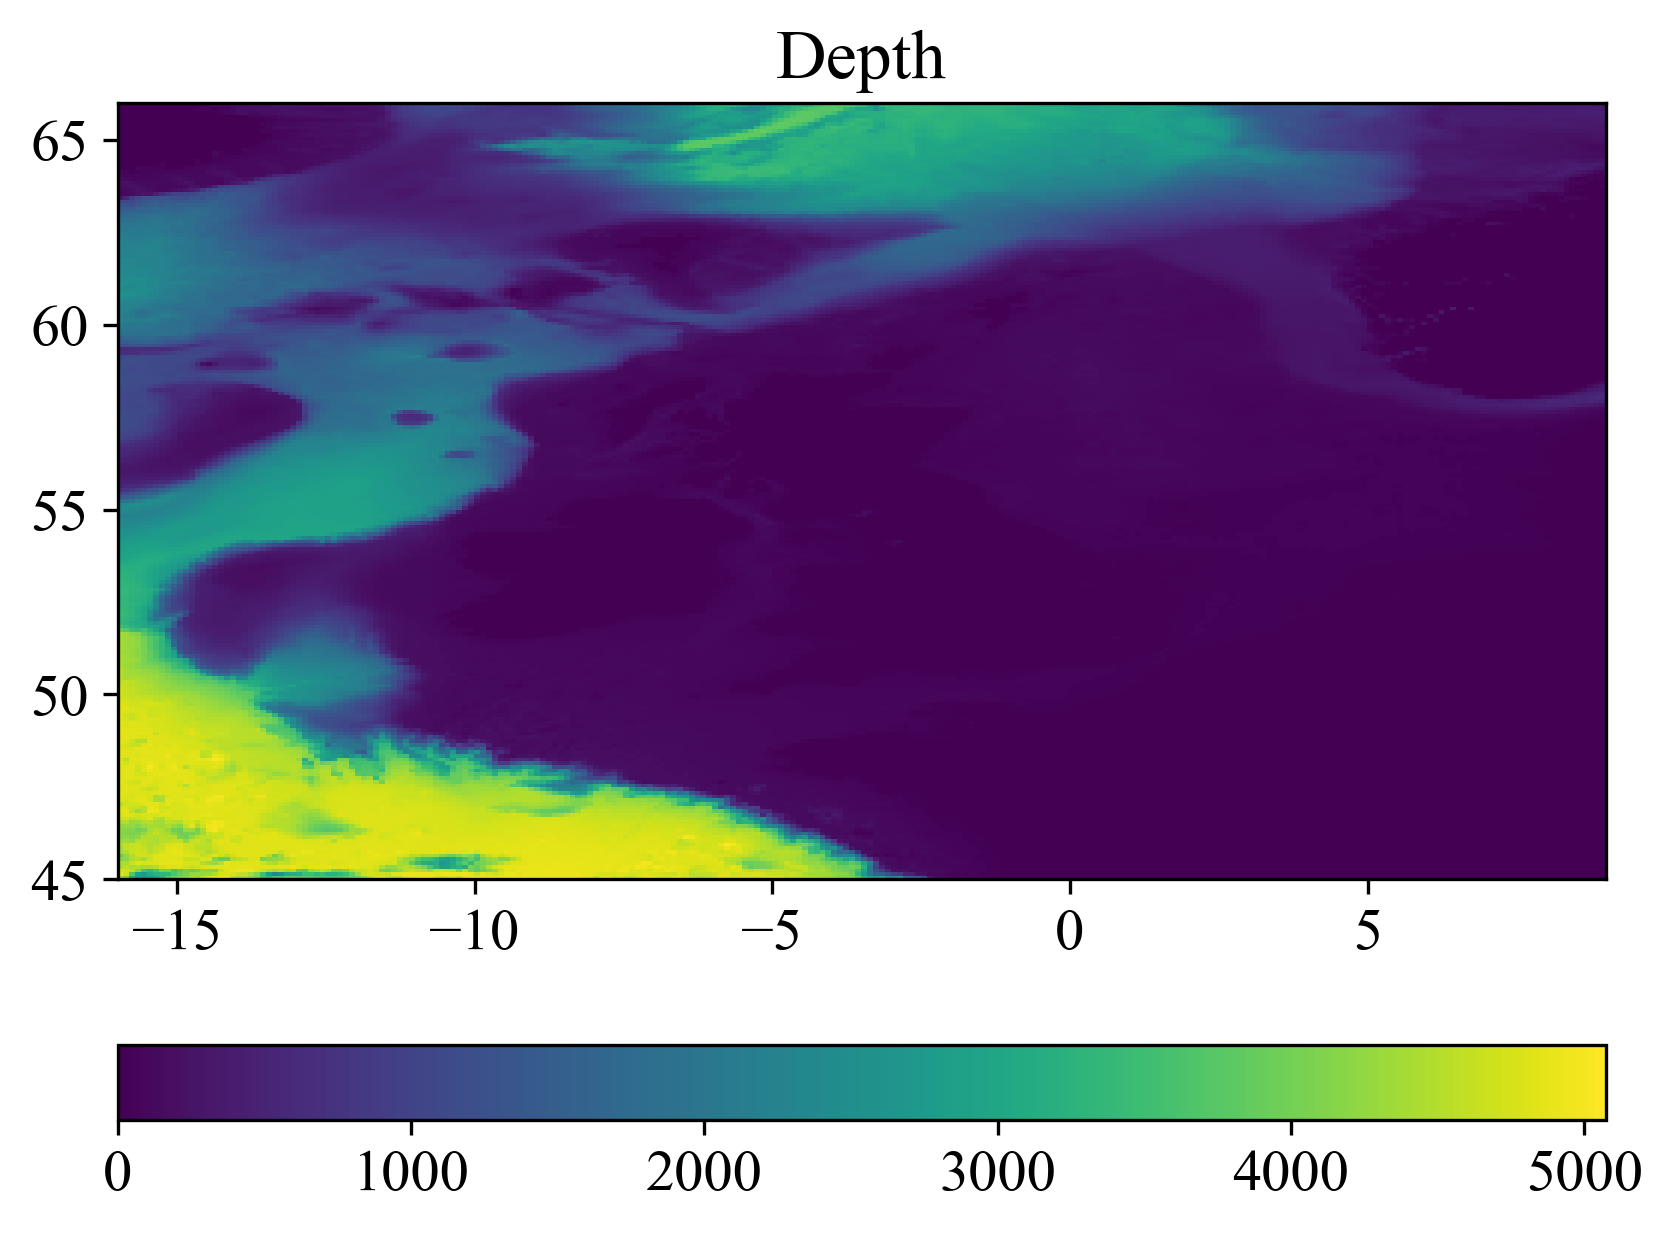

size(b) = (251, 211)


In [64]:
bx, by, b = load_bath(bathname, true, longrid, latgrid)
@show size(b)

if doplot
    fig = PyPlot.figure()
    ax = PyPlot.subplot(111)
    pcolor(bx,by,b', vmin=0.); 
    colorbar(orientation="horizontal")
    title("Depth")
    show()
end

### Metrics

In [6]:
mask, (pm, pn),(xi, yi) = DIVAnd.DIVAnd_rectdom(longrid, latgrid);
xi, yi, mask = DIVAnd.load_mask(bathname, true, longrid, latgrid, 0.0);
xx, yy = ndgrid(xi, yi);

## Interpolation

In [87]:
function read_coords_species(datafile::String, species::Union{String,SubString{String}})
    data = readdlm(datafile, ',');
    colnames = data[1,:]
    dates = data[2:end,2]
    lon = data[2:end,3]
    lat = data[2:end,4]
    col_index = findall(colnames .== species)[1]
    @info("Column index for $(species): $(col_index)");
    occur_species = data[2:end,col_index]
    occur_pre = findall(occur_species .== "TRUE")
    occur_abs = findall(occur_species .== "FALSE")
    lon_presence = lon[occur_pre]
    lat_presence = lat[occur_pre]
    lon_absence = lon[occur_abs]
    lat_absence = lat[occur_abs];
    return Float64.(lon_presence), Float64.(lat_presence), Float64.(lon_absence), Float64.(lat_absence)
end

read_coords_species (generic function with 3 methods)

In [34]:
species = "Abludomelita_obtusata"
@time lon_pre, lat_pre, lon_abs, lat_abs = read_coords_species(datafile, species);
# Test
length(lon_pre) == 2097
length(lat_abs) == 66463

  0.568020 seconds (7.90 M allocations: 269.181 MiB, 9.85% gc time)


┌ Info: Column index for Abludomelita_obtusata: 9
└ @ Main In[22]:8


true

In [28]:
function decorate_map_domain(ax, plotcoast=true; domain=[-16., 9., 45., 66.], 
        dlon::Float64=2., dlat::Float64=2.)
    PyPlot.grid(linewidth=0.2)
    if plotcoast
        ax.add_feature(coast, color=".6",
            edgecolor="k", zorder=5)
    end
    ax.set_xlim(domain[1], domain[2])
    ax.set_ylim(domain[3], domain[4])
    ax.set_xticks(domain[1]:dlon:domain[2])
    ax.set_yticks(domain[3]:dlat:domain[4])
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
end

decorate_map_domain (generic function with 2 methods)

### Compute heatmaps

In [65]:
@time dens2, LHM2, LCV2, LSCV2 = DIVAnd_heatmap(mask, (pm,pn), (xx, yy), 
    (lon_pre, lat_pre), ones(length(lat_pre)), 0.2);
@time dens3, LHM3, LCV3, LSCV3 = DIVAnd_heatmap(mask, (pm,pn), (xx, yy), 
    (lon_abs, lat_abs), ones(length(lat_abs)), 0.2);

 39.980089 seconds (191.65 k allocations: 13.588 GiB, 2.32% gc time)


┌ Warning: Data array size (66463,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 41.917574 seconds (2.17 M allocations: 12.739 GiB, 0.89% gc time)


Finally, the probability field is computed as:
```
d = npre * dens2 / (npre * dens2 + nabs * dens3)
```
The reason for this equation is that the heatmap are computed so that their integral over the domain is 1, whatever the number of observations. 

In [66]:
npre = length(lon_pre)
nabs = length(lon_abs)
d = npre .* dens2 ./ (npre .* dens2 .+ nabs .* dens3);

### Plotting

In [107]:
function plot_heatmap2(longrid::StepRangeLen, latgrid::StepRangeLen,
    dens::Array, lonpre::Vector, latpre::Vector, lonabs::Vector, latabs::Vector,
    titletext::String, figname::String="", vmin=0., vmax=1.0)

    llon, llat = ndgrid(longrid, latgrid)
    myproj = ccrs.PlateCarree()
    fig = PyPlot.figure(figsize=(12,8))
    ax = PyPlot.subplot(111, projection=myproj)
    ax.plot(lonpre, latpre, "wo", markersize=1., zorder=3, alpha=.25)
    ax.plot(lonabs, latabs, "ko", markersize=1., zorder=3, alpha=.25)
    pcm = ax.pcolor(llon, llat, dens, cmap=PyPlot.cm.hot_r, zorder=2, vmin=vmin, vmax=vmax)
    colorbar(pcm, orientation="vertical")
    decorate_map_domain(ax, dlon=4.)
    title(titletext)
    if length(figname) > 0
        PyPlot.savefig(figname, dpi=300, bbox_inches="tight")
        PyPlot.close()
    else
        PyPlot.show()
    end
end

plot_heatmap2 (generic function with 4 methods)

In [108]:
function plot_error2(longrid::StepRangeLen, latgrid::StepRangeLen,
    error::Array, titletext::String="", figname::String="")

    llon, llat = ndgrid(longrid, latgrid)
    myproj = ccrs.PlateCarree()
    fig = PyPlot.figure(figsize=(12,8))
    ax = PyPlot.subplot(111, projection=myproj)
    pcm = ax.pcolor(llon, llat, error, zorder=2, cmap=PyPlot.cm.RdYlGn_r)
    colorbar(pcm, orientation="vertical")
    decorate_map_domain(ax, dlon=4.)
    title(titletext)
    if length(figname) > 0
        PyPlot.savefig(figname, dpi=300, bbox_inches="tight")
        PyPlot.close()
    else
        PyPlot.show()
    end
end

plot_error2 (generic function with 3 methods)

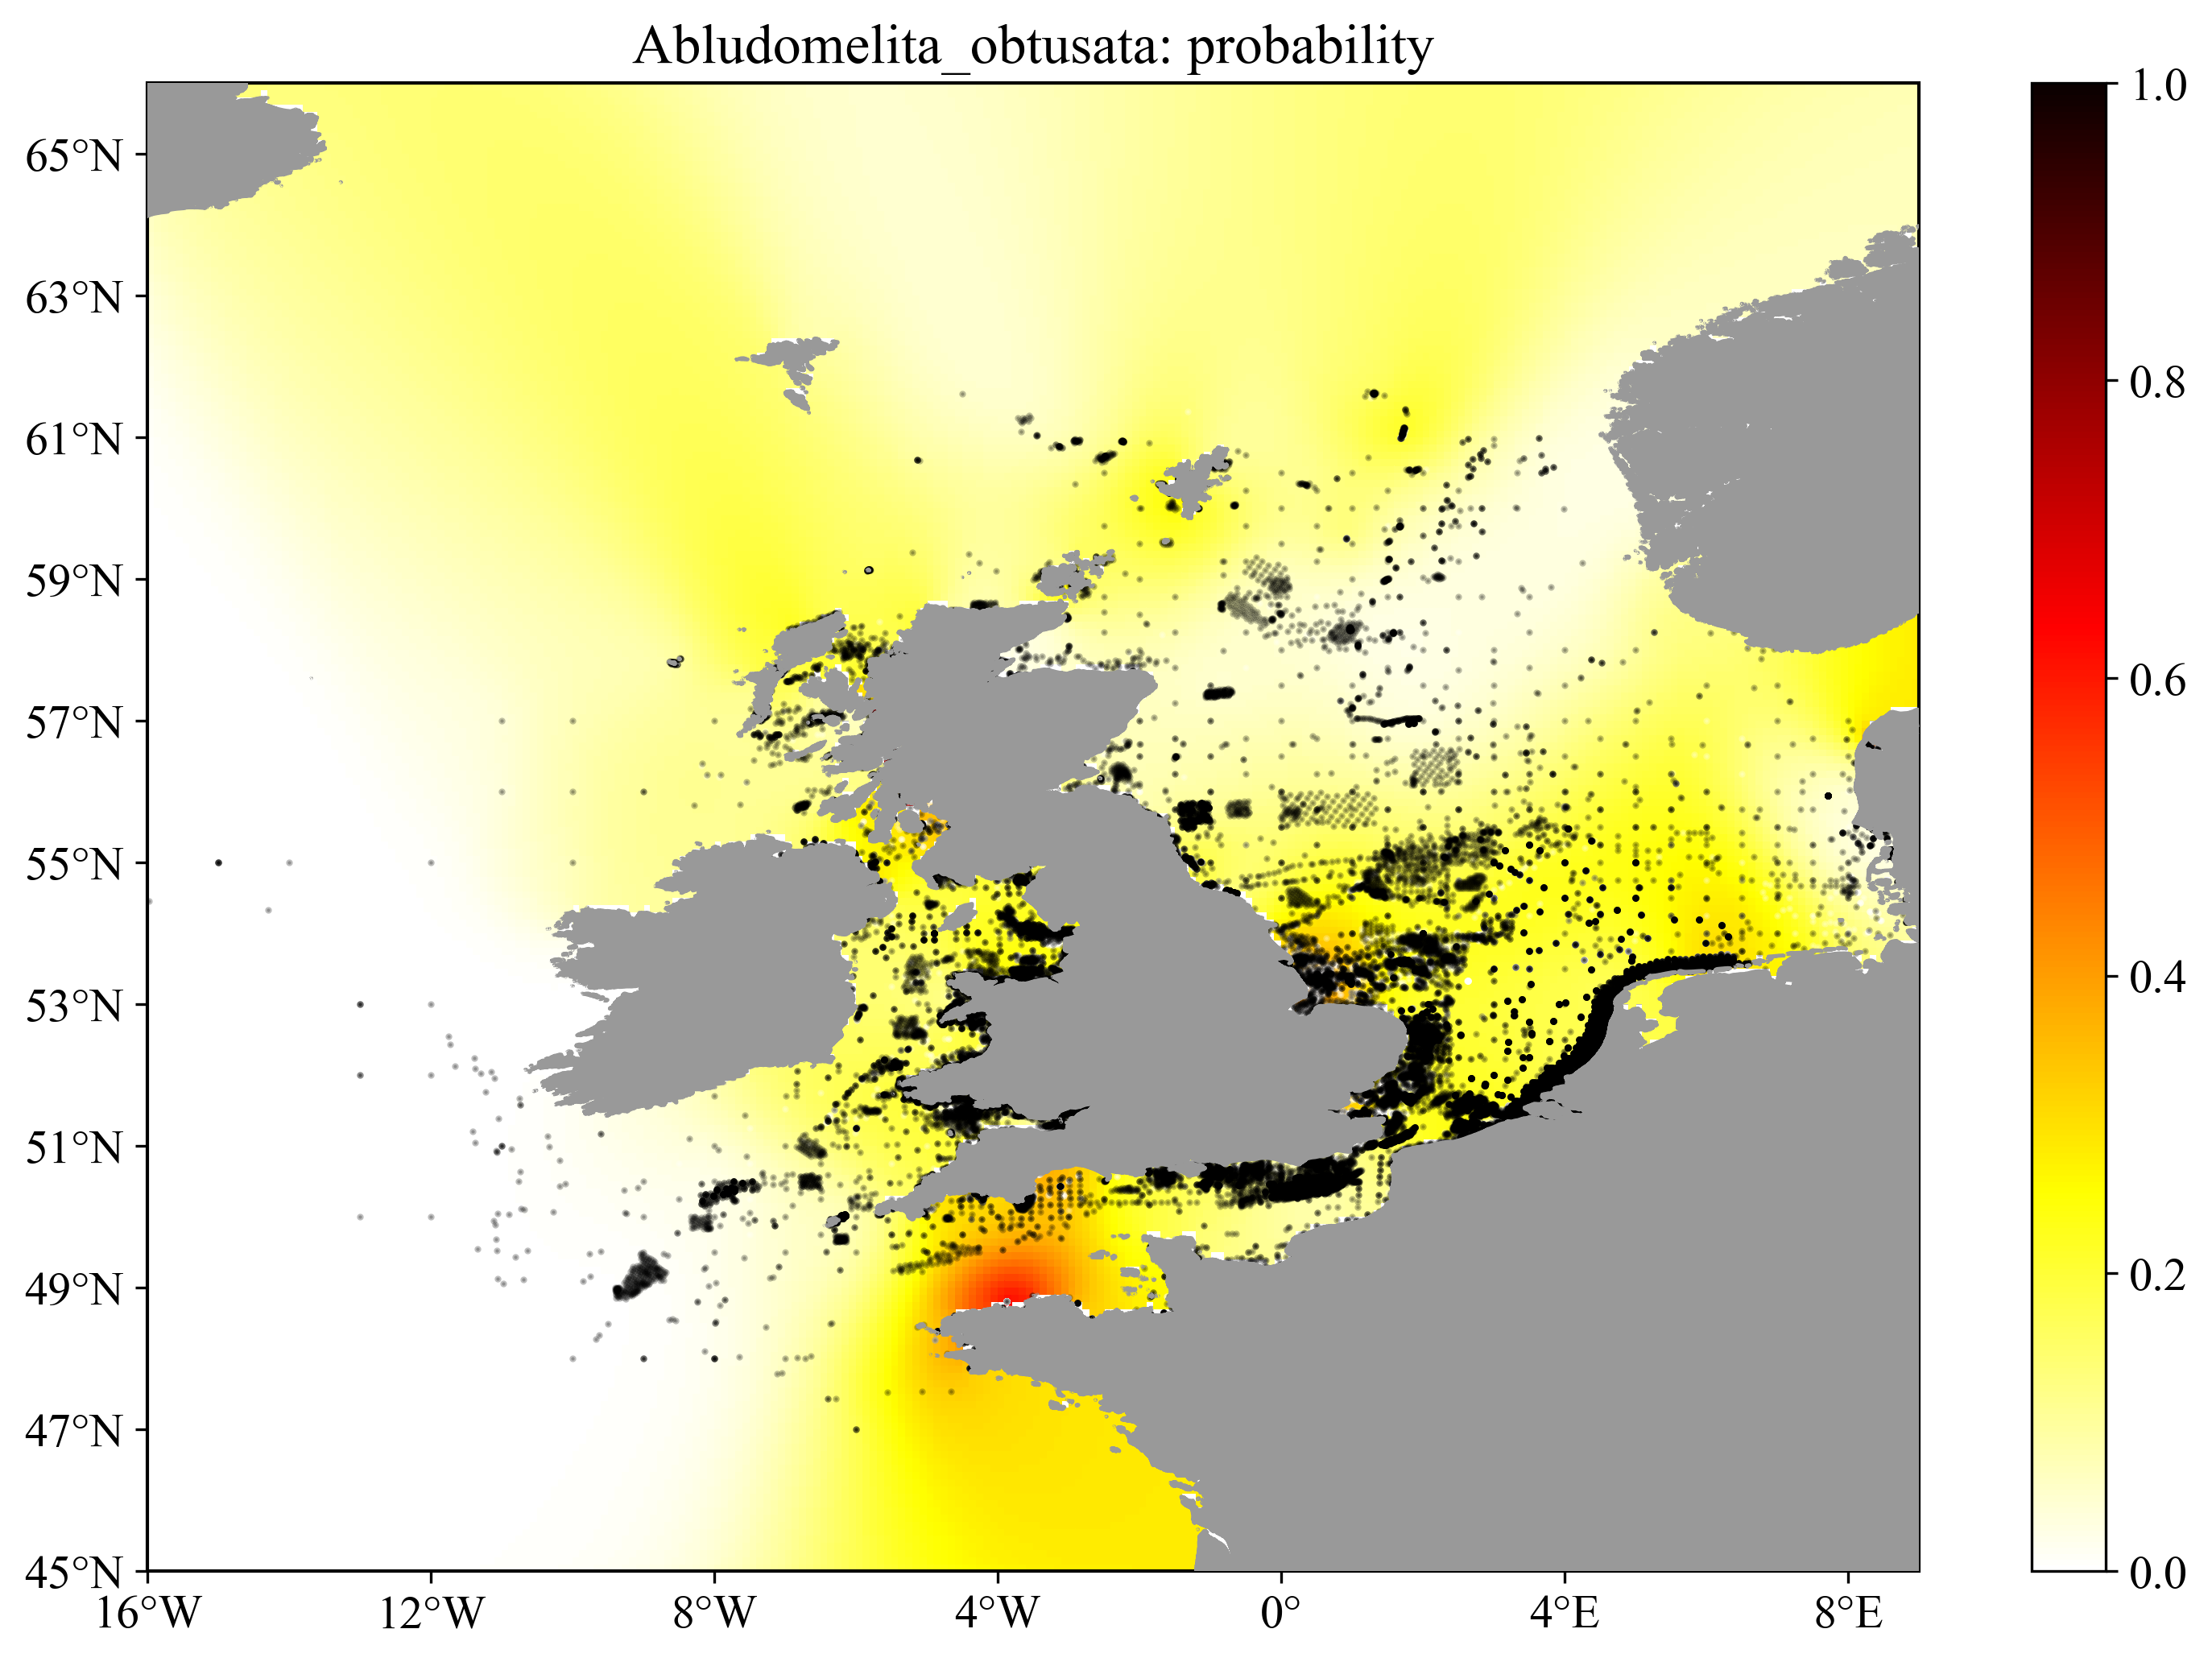

In [109]:
if doplot
    plot_heatmap2(longrid, latgrid, d, lon_pre, lat_pre, lon_abs, lat_abs,
        "$(species): probability")
    #pcolormesh(longrid, latgrid, mask', cmap=PyPlot.cm.binary_r)
end

## Loop on all the files

In [110]:
function get_species_names(datafile::String)::Array
    firstline = []
    open(datafile, "r") do df
        firstline = readline(df)
    end
    return split(firstline, ",")[5:end]
end

get_species_names (generic function with 2 methods)

In [111]:
speciesnamelist = get_species_names(datafile)

for species in speciesnamelist
    
    speciesslug = get_species_slug(String(species))
    @info(speciesslug)
    @info("Working on species $(species)");
    lon_pre, lat_pre, lon_abs, lat_abs = read_coords_species(datafile, species);
    
    @time dens2, LHM2, LCV2, LSCV2 = DIVAnd_heatmap(mask, (pm,pn), (xx, yy), 
    (lon_pre, lat_pre), ones(length(lat_pre)), 0.5);
    @time dens3, LHM3, LCV3, LSCV3 = DIVAnd_heatmap(mask, (pm,pn), (xx, yy), 
    (lon_abs, lat_abs), ones(length(lat_abs)), 0.5);
    
    npre = length(lon_pre)
    nabs = length(lon_abs)
    d = npre .* dens2 ./ (npre .* dens2 .+ nabs .* dens3);
    
    @info("Computing error field with CPME")
    lon = [lon_pre ; lon_abs]
    lat = [lat_pre ; lat_abs]
    
    cpme = DIVAnd_cpme(mask, (pm, pn), (xx, yy), (lon, lat), 
        ones(length(lon)), 0.5, 5.);
    
    if doplot
    plot_heatmap2(longrid, latgrid, d, lon_pre, lat_pre, lon_abs, lat_abs,
        "$(species): probability", joinpath(figdir, "$(speciesslug)_density.png"))
    end
    
    if doplot
        plot_error2(longrid, latgrid, cpme, "$(species)", 
            joinpath(figdir, "$(speciesslug)_error.png"))
    end   
    
    create_nc_results(joinpath(outputdir, "$(speciesslug)_density.nc"), 
        longrid, latgrid, d, String(species));
    
    # Add the error field
    write_nc_error(joinpath(outputdir, "$(speciesslug)_density.nc"), cpme);
end

┌ Info: Abra_alba
└ @ Main In[111]:6
┌ Info: Working on species Abra_alba
└ @ Main In[111]:7
┌ Info: Column index for Abra_alba: 5
└ @ Main In[87]:8
┌ Warning: Data array size (14068,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 37.722707 seconds (505.75 k allocations: 6.264 GiB, 0.54% gc time)


┌ Warning: Data array size (65977,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 43.036409 seconds (2.15 M allocations: 12.477 GiB, 2.19% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[111]:19
┌ Info: Amphiura_filiformis
└ @ Main In[111]:6
┌ Info: Working on species Amphiura_filiformis
└ @ Main In[111]:7
┌ Info: Column index for Amphiura_filiformis: 6
└ @ Main In[87]:8


113.334921 seconds (507.80 k allocations: 36.071 GiB, 0.79% gc time)


┌ Warning: Data array size (74293,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 33.886053 seconds (2.38 M allocations: 11.184 GiB, 2.40% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[111]:19
┌ Info: Diplocirrus_glaucus
└ @ Main In[111]:6
┌ Info: Working on species Diplocirrus_glaucus
└ @ Main In[111]:7
┌ Info: Column index for Diplocirrus_glaucus: 7
└ @ Main In[87]:8


101.581820 seconds (363.47 k allocations: 25.856 GiB, 0.65% gc time)


┌ Warning: Data array size (64473,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 56.016133 seconds (2.10 M allocations: 11.888 GiB, 1.66% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[111]:19
┌ Info: Amphiura_chiajei
└ @ Main In[111]:6
┌ Info: Working on species Amphiura_chiajei
└ @ Main In[111]:7
┌ Info: Column index for Amphiura_chiajei: 8
└ @ Main In[87]:8


 34.505309 seconds (155.30 k allocations: 11.262 GiB, 0.77% gc time)


┌ Warning: Data array size (66785,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 37.664554 seconds (2.17 M allocations: 12.411 GiB, 2.17% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[111]:19
┌ Info: Abludomelita_obtusata
└ @ Main In[111]:6
┌ Info: Working on species Abludomelita_obtusata
└ @ Main In[111]:7
┌ Info: Column index for Abludomelita_obtusata: 9
└ @ Main In[87]:8


 41.131108 seconds (188.59 k allocations: 13.588 GiB, 0.86% gc time)


┌ Warning: Data array size (66463,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 40.823508 seconds (2.17 M allocations: 12.739 GiB, 0.63% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[111]:19
┌ Info: Bicellariella_ciliata
└ @ Main In[111]:6
┌ Info: Working on species Bicellariella_ciliata
└ @ Main In[111]:7
┌ Info: Column index for Bicellariella_ciliata: 10
└ @ Main In[87]:8


 41.130178 seconds (194.30 k allocations: 13.995 GiB, 2.36% gc time)


┌ Warning: Data array size (66401,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 40.974300 seconds (2.17 M allocations: 12.772 GiB, 0.92% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[111]:19
┌ Info: Megaluropus_agilis
└ @ Main In[111]:6
┌ Info: Working on species Megaluropus_agilis
└ @ Main In[111]:7
┌ Info: Column index for Megaluropus_agilis: 11
└ @ Main In[87]:8


 35.657037 seconds (171.07 k allocations: 12.499 GiB, 2.31% gc time)


┌ Warning: Data array size (66641,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 37.592435 seconds (2.17 M allocations: 12.758 GiB, 0.97% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[111]:19
┌ Info: Sigalion_mathildae
└ @ Main In[111]:6
┌ Info: Working on species Sigalion_mathildae
└ @ Main In[111]:7
┌ Info: Column index for Sigalion_mathildae: 12
└ @ Main In[87]:8


 35.089984 seconds (166.12 k allocations: 12.144 GiB, 0.75% gc time)


┌ Warning: Data array size (66697,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 38.381767 seconds (2.17 M allocations: 12.709 GiB, 2.30% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[111]:19
┌ Info: Callianassa_subterranea
└ @ Main In[111]:6
┌ Info: Working on species Callianassa_subterranea
└ @ Main In[111]:7
┌ Info: Column index for Callianassa_subterranea: 13
└ @ Main In[87]:8


 43.946950 seconds (189.67 k allocations: 13.669 GiB, 0.73% gc time)


┌ Warning: Data array size (67049,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 41.598370 seconds (2.19 M allocations: 12.717 GiB, 0.65% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[111]:19
┌ Info: Acrocnida_brachiata
└ @ Main In[111]:6
┌ Info: Working on species Acrocnida_brachiata
└ @ Main In[111]:7
┌ Info: Column index for Acrocnida_brachiata: 14
└ @ Main In[87]:8


 33.467029 seconds (148.66 k allocations: 10.900 GiB, 2.44% gc time)


┌ Warning: Data array size (66895,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 39.062768 seconds (2.18 M allocations: 12.608 GiB, 0.90% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[111]:19
┌ Info: Littorina_littorea
└ @ Main In[111]:6
┌ Info: Working on species Littorina_littorea
└ @ Main In[111]:7
┌ Info: Column index for Littorina_littorea: 15
└ @ Main In[87]:8


 31.640081 seconds (113.16 k allocations: 8.299 GiB, 2.18% gc time)


┌ Warning: Data array size (67275,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 44.988675 seconds (2.19 M allocations: 12.797 GiB, 0.89% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[111]:19
┌ Info: Aequipecten_opercularis
└ @ Main In[111]:6
┌ Info: Working on species Aequipecten_opercularis
└ @ Main In[111]:7
┌ Info: Column index for Aequipecten_opercularis: 16
└ @ Main In[87]:8


 30.282197 seconds (170.33 k allocations: 12.409 GiB, 0.79% gc time)


┌ Warning: Data array size (78087,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 39.167335 seconds (2.52 M allocations: 12.609 GiB, 2.05% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[111]:19
┌ Info: Bathyporeia_tenuipes
└ @ Main In[111]:6
┌ Info: Working on species Bathyporeia_tenuipes
└ @ Main In[111]:7
┌ Info: Column index for Bathyporeia_tenuipes: 17
└ @ Main In[87]:8


 26.354496 seconds (127.24 k allocations: 9.377 GiB, 0.84% gc time)


┌ Warning: Data array size (67139,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 45.762936 seconds (2.19 M allocations: 12.608 GiB, 0.56% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[111]:19
┌ Info: Lumbrineriopsis_paradoxa
└ @ Main In[111]:6
┌ Info: Working on species Lumbrineriopsis_paradoxa
└ @ Main In[111]:7
┌ Info: Column index for Lumbrineriopsis_paradoxa: 18
└ @ Main In[87]:8


 62.199294 seconds (191.61 k allocations: 13.808 GiB, 1.56% gc time)


┌ Warning: Data array size (66432,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 55.995828 seconds (2.17 M allocations: 12.797 GiB, 0.70% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[111]:19
┌ Info: Spio_armata
└ @ Main In[111]:6
┌ Info: Working on species Spio_armata
└ @ Main In[111]:7
┌ Info: Column index for Spio_armata: 19
└ @ Main In[87]:8


 56.379066 seconds (163.82 k allocations: 11.974 GiB, 0.48% gc time)


┌ Warning: Data array size (66721,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 59.517249 seconds (2.18 M allocations: 12.784 GiB, 1.56% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[111]:19
┌ Info: Schizomavella_(Schizomavella)_auriculata
└ @ Main In[111]:6
┌ Info: Working on species Schizomavella_(Schizomavella)_auriculata
└ @ Main In[111]:7
┌ Info: Column index for Schizomavella_(Schizomavella)_auriculata: 20
└ @ Main In[87]:8


 49.699797 seconds (125.79 k allocations: 9.273 GiB, 0.49% gc time)


┌ Warning: Data array size (67155,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 78.456192 seconds (2.19 M allocations: 12.778 GiB, 0.42% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[111]:19
┌ Info: Amphiura_(Ophiopeltis)_securigera
└ @ Main In[111]:6
┌ Info: Working on species Amphiura_(Ophiopeltis)_securigera
└ @ Main In[111]:7
┌ Info: Column index for Amphiura_(Ophiopeltis)_securigera: 21
└ @ Main In[87]:8


 52.361273 seconds (117.47 k allocations: 8.682 GiB, 1.49% gc time)


┌ Warning: Data array size (67250,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 75.445250 seconds (2.19 M allocations: 12.804 GiB, 0.56% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[111]:19
┌ Info: Diplocirrus_stopbowitzi
└ @ Main In[111]:6
┌ Info: Working on species Diplocirrus_stopbowitzi
└ @ Main In[111]:7
┌ Info: Column index for Diplocirrus_stopbowitzi: 22
└ @ Main In[87]:8


  9.213241 seconds (31.75 k allocations: 2.567 GiB, 0.73% gc time)


┌ Warning: Data array size (68228,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 66.261600 seconds (2.22 M allocations: 12.810 GiB, 1.43% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[111]:19
